In [ ]:
# default_exp fasta

# FASTA

> Functions related to generating spectra from FASTA files

This notebook contains all functions related to creating spectra from FASTA files. In brief, what we are doing is the following:

1. Read a FASTA file and digest the sequences
2. For each peptide, calculate a synthetic spectrum and precursor mass
3. Save spectra

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#hide
import warnings
from numba import NumbaPendingDeprecationWarning

warnings.simplefilter("ignore", category=NumbaPendingDeprecationWarning)

## Cleaving

For cleaving, we use regular expressions to find potential cleavages sites and write the wrapper `cleave_sequence` to use it.

In [ ]:
#export
from alphapept import constants
import re

def get_missed_cleavages(sequences, n_missed_cleavages):
    """
    Combine cleaved sequences to get sequences with missed cleavages
    """
    missed = []
    for k in range(len(sequences)-n_missed_cleavages):
        missed.append(''.join(sequences[k-1:k+n_missed_cleavages]))
        
    return missed


def cleave_sequence(
    sequence="",
    num_missed_cleavages=0,
    protease="trypsin",
    min_length=6,
    max_length=65,
    **kwargs
):
    
    proteases = constants.protease_dict
    pattern = proteases[protease]
    
    p = re.compile(pattern)

    cutpos = [m.start()+1 for m in p.finditer(sequence)]
    cutpos.insert(0,0)
    cutpos.append(len(sequence))
    
    base_sequences = [sequence[cutpos[i]:cutpos[i+1]] for i in range(len(cutpos)-1)]

    sequences = base_sequences.copy()

    for i in range(1, num_missed_cleavages+1):
        sequences.extend(get_missed_cleavages(base_sequences, i))
    
    sequences = [_ for _ in sequences if len(_)>=min_length and len(_)<=max_length]
    
    return sequences

In [ ]:
protease = "trypsin"
num_missed_cleavages = 0
min_length, max_length = 6, 65

cleave_sequence('ABCDEFGHIJKLMNOPQRST', num_missed_cleavages, protease, min_length, max_length)

['ABCDEFGHIJK', 'LMNOPQR']

In [ ]:
#hide
def test_cleave_sequence():
    
    protease = "trypsin"
    min_length, max_length = 6, 65

    assert set(cleave_sequence('ABCDEFGHIJKLMNOPQRST', 0, protease, min_length, max_length)) == set(['ABCDEFGHIJK', 'LMNOPQR'])
    assert set(cleave_sequence('ABCDEFGHIJKLMNOPQRST', 1, protease, min_length, max_length)) == set(['ABCDEFGHIJK', 'LMNOPQR', 'ABCDEFGHIJKLMNOPQR'])

    test_cleave_sequence()

## Missed and internal cleavages
The following are helper functions to retrieve the number of missed cleavages and internal cleavage sites for each sequence.

In [ ]:
#export
import re
from alphapept import constants

def count_missed_cleavages(sequence="", protease="trypsin",**kwargs):
    """
    Counts the number of missed cleavages for a given sequence and protease
    """
    proteases = constants.protease_dict
    protease = proteases[protease]
    p = re.compile(protease)
    n_missed = len(p.findall(sequence))
    return n_missed

def count_internal_cleavages(sequence="", protease="trypsin",**kwargs):
    """
    Counts the number of internal cleavage sites for a given sequence and protease
    """
    proteases = constants.protease_dict
    protease = proteases[protease]
    match = re.search(protease,sequence[-1]+'_')
    if match:
        n_internal = 0
    else:
        n_internal = 1
    return n_internal

In [ ]:
protease = "trypsin"
print(count_missed_cleavages('ABCDEFGHIJKLMNOPQRST', protease))

protease = "trypsin"
print(count_internal_cleavages('ABCDEFGHIJKLMNOPQRST', protease))

2
1


In [ ]:
#hide
def test_get_missed_cleavages():  
    assert count_missed_cleavages('ABCDEFGHIJKLMNOPQRST', 'trypsin') == 2
    assert count_missed_cleavages('ABCDEFGHIJKLMNOPQRST', 'clostripain') == 1
    
test_get_missed_cleavages()

def test_get_internal_cleavages():
    assert count_internal_cleavages('ABCDEFGHIJKLMNOPQRST', 'trypsin') == 1
    assert count_internal_cleavages('ABCDEFGHIJKLMNOPQRSTK', 'trypsin') == 0

test_get_internal_cleavages()

## Parsing

Peptides are composed out of amino acids that are written in capital letters - `PEPTIDE`. to distinguish modifications, they are written in lowercase such as `PEPTIoxDE` and can be of arbitrary length. For a modified amino acid, the modification preceds the letter of the amino acid. Decoys are indicated with a underscore, hence the `parse` function splits after `_`. When parsing, the peptide string is converted into a numba-compatible list so that each element can be determined with the `mass_dict` from `alphapept.constants`.

In [ ]:
#export
from numba import njit
from numba.typed import List

@njit
def parse(peptide):
    """
    Parser to parse peptide strings
    """
    if "_" in peptide:
        peptide = peptide.split("_")[0]
    parsed = List()
    string = ""

    for i in peptide:
        string += i
        if i.isupper():
            parsed.append(string)
            string = ""

    return parsed

def list_to_numba(a_list):
    numba_list = List()

    for element in a_list:
        numba_list.append(element)

    return numba_list

In [ ]:
print(parse('PEPTIDE'))
print(parse('PEPoxTIDE'))

[P, E, P, T, I, D, E]
[P, E, P, oxT, I, D, E]


In [ ]:
#hide
def test_parse():
    peptide = "PEPTIDE"
    assert parse(peptide) == list_to_numba(["P", "E", "P", "T", "I", "D", "E"])
    peptide = "PEPoxTIDE"
    assert parse(peptide) == list_to_numba(["P", "E", "P", "oxT", "I", "D", "E"])
    peptide = "PEPTIDE_decoy"
    assert parse(peptide) == list_to_numba(["P", "E", "P", "T", "I", "D", "E"])
    
test_parse()

## Decoy

The decoy strategy that is employed is a pseudo-reversal of the peptide sequence, keeping only the terminal amino-acid and reversing the rest. Additionally, we can call the functions `swap_KR` and and `swap_AL` that will swap the respective AAs. The function `swap_KR` will only swap terminal AAs. The swapping functions only work if the AA is not modified.

In [ ]:
#export
@njit
def get_decoy_sequence(peptide, pseudo_reverse=True, AL_swap=False, KR_swap = False):
    """
    Reverses a sequence and adds the '_decoy' tag.

    """
    pep = parse(peptide)
    if pseudo_reverse:        
        rev_pep = pep[:-1][::-1]
        rev_pep.append(pep[-1])
    else:
        rev_pep = pep[::-1]

    if AL_swap:
        rev_pep = swap_AL(rev_pep)

    if KR_swap:
        rev_pep = swap_KR(rev_pep)

    rev_pep = "".join(rev_pep)

    return rev_pep


@njit
def swap_KR(peptide):
    """
    Swaps a terminal K or R. Note: Only if AA is not modified.
    """
    if peptide[-1] == 'K':
        peptide[-1] = 'R'
    elif peptide[-1] == 'R':
        peptide[-1] = 'K'

    return peptide


@njit
def swap_AL(peptide):
    """
    Swaps a A with L. Note: Only if AA is not modified.
    """
    i = 0
    while i < len(range(len(peptide) - 1)):
        if peptide[i] == "A":
            peptide[i] = peptide[i + 1]
            peptide[i + 1] = "A"
            i += 1
        elif peptide[i] == "L":
            peptide[i] = peptide[i + 1]
            peptide[i + 1] = "L"
            i += 1
        i += 1

    return peptide

def get_decoys(peptide_list):
    """
    Wrapper to get decoys for lists of peptides
    """
    decoys = []
    decoys.extend([get_decoy_sequence(peptide) for peptide in peptide_list])
    return decoys

def add_decoy_tag(peptides):
    """
    Adds a _decoy tag to a list of peptides
    """
    return [peptide + "_decoy" for peptide in peptides]

In [ ]:
print(swap_AL(parse('KKKALKKK')))
print(swap_KR(parse('AAAKRAAA')))

[K, K, K, L, A, K, K, K]
[A, A, A, K, R, A, A, A]


In [ ]:
print(get_decoy_sequence('PEPTIDE'))

DITPEPE


In [ ]:
print(get_decoys(['ABC','DEF','GHI']))

['BAC', 'EDF', 'HGI']


In [ ]:
#hide

def test_swap_AL():
    assert swap_AL(parse("ABCDEF")) == parse("BACDEF")
    assert swap_AL(parse("GHIKLM")) == parse("GHIKML")
    assert swap_AL(parse("FEDCBA")) == parse("FEDCBA")
    assert swap_AL(parse("GHIKL")) == parse("GHIKL")
    assert swap_AL(parse("ABCDEFGHIKLM")) == parse("BACDEFGHIKML")
    assert swap_AL(parse("BBAcCD")) == parse("BBcCAD")
    assert swap_AL(parse("FEDCBA")) == parse("FEDCBA")

test_swap_AL()

def test_swapKR():
    assert swap_KR(parse("ABCDEK")) == parse("ABCDER")
    assert swap_KR(parse("ABCDER")) == parse("ABCDEK")
    assert swap_KR(parse("ABCDEF")) == parse("ABCDEF")
    assert swap_KR(parse("KABCDEF")) == parse("KABCDEF")
    assert swap_KR(parse("KABCRDEF")) == parse("KABCRDEF")
    assert swap_KR(parse("KABCKDEF")) == parse("KABCKDEF")

test_swapKR()
    
def test_get_decoy_sequence():
    peptide = "PEPTIDER"
    assert get_decoy_sequence(peptide, pseudo_reverse=False) == "REDITPEP"
    assert get_decoy_sequence(peptide) == "EDITPEPR"
    assert get_decoy_sequence(peptide, KR_swap=True) == "EDITPEPK"
    
test_get_decoy_sequence()

## Modifications

To add modifications to the peptides we distinguish fixed and variable modifications. Additionally, we make a distinciton between whether the modification is only terminal or not. 

### Fixed Modifications
Fixed modifications are implemented by passing a list with modified AAs that should be replaced. As we only have one letter AAs the remainder is the modification. 

In [ ]:
#export
def add_fixed_mods(seqs, mods_fixed, **kwargs):
    """
    Adds fixed modifications to sequences.
    """
    if not mods_fixed:
        return seqs
    else:
        for mod_aa in mods_fixed:
            seqs = [seq.replace(mod_aa[-1], mod_aa) for seq in seqs]
        return seqs

In [ ]:
mods_fixed = ['cC','bB']
peptide_list = ['ABCDEF']

add_fixed_mods(peptide_list, mods_fixed)

['AbBcCDEF']

In [ ]:
#hide
def test_add_fixed_mods():
    mods_fixed = ['cC']
    peptide_list = ['ABCDEF']

    peptides_new = add_fixed_mods(peptide_list, [])
    assert peptides_new == peptide_list
    
    peptides_new = add_fixed_mods(peptide_list, mods_fixed)
    assert peptides_new == ['ABcCDEF']
    
test_add_fixed_mods()

### Variable Modifications

To employ variable modifications, we use the function `get_mod_pos` that returns a list of tuples with all possible modifications when giving a dicitionary with variable modifications.  

In [ ]:
#export
def get_mod_pos(variable_mods_r, sequence):
    """
    Returns a list with of tuples with all possibilities for modified an unmodified AAs.
    """
    modvar = []
    for c in sequence:
        if c in variable_mods_r.keys():
            modvar.append((c, variable_mods_r[c]))
        else:
            modvar.append((c,))

    return modvar

In [ ]:
mods_variable_dict = {'M':'oxM'}
peptide = 'AMAMA'
get_mod_pos(mods_variable_dict, peptide)

[('A',), ('M', 'oxM'), ('A',), ('M', 'oxM'), ('A',)]

In [ ]:
#hide

def test_get_mod_pos():
    
    mods_variable_dict = {'M':'oxM'}
    peptide = 'AMAMA'
    assert set(get_mod_pos(mods_variable_dict, peptide)) == set([('A',), ('M', 'oxM'), ('A',), ('M', 'oxM'), ('A',)])
    
test_get_mod_pos()

To now generate all isoforms, we employ the function `get_isoforms` that generates all isoforms for a given peptide. As the number of isoforms can become large, we restrict it with the parameter `max_isoforms`.

In [ ]:
#export

from itertools import product
def get_isoforms(variable_mods_r, sequence, max_isoforms):
    """
    Function to generate isoforms for a given peptide - returns a list of isoforms.
    The original sequence is included in the list
    """
    modvar = get_mod_pos(variable_mods_r, sequence)
    isoforms = []
    i = 0
    for o in product(*modvar):
        if i < max_isoforms:
            i += 1
            isoforms.append("".join(o))

        else:
            break

    return isoforms

In [ ]:
mods_variable_dict = {'M':'oxM'}
peptide = 'AMAMA'
max_isoforms = 1024
get_isoforms(mods_variable_dict, peptide, max_isoforms)

['AMAMA', 'AMAoxMA', 'AoxMAMA', 'AoxMAoxMA']

Lastly, we define the wrapper `add_variable_mods` so that the functions can be called for lists of peptides and a list of variable modifications.

In [ ]:
#export 
from itertools import chain

def add_variable_mods(peptide_list, mods_variable, max_isoforms, **kwargs):
    if not mods_variable:
        return peptide_list
    else:
        mods_variable_r = {}
        for _ in mods_variable:
            mods_variable_r[_[-1]] = _

        peptide_list = [get_isoforms(mods_variable_r, peptide, max_isoforms) for peptide in peptide_list]
        return list(chain.from_iterable(peptide_list))

In [ ]:
peptide_list = ['AMA', 'AAC']
mods_variable = ['oxM','amC']
max_isoforms = 1024

add_variable_mods(peptide_list, mods_variable, max_isoforms)

['AMA', 'AoxMA', 'AAC', 'AAamC']

In [ ]:
#hide
def test_add_variable_mods():
    mods_variable = ['oxM']
    peptide = ['AMAMA']

    peptides_new = add_variable_mods(peptide, [], 1024)
    assert peptides_new == peptide

    peptides_new = add_variable_mods(peptide, mods_variable, 1024)

    assert set(['AMAMA', 'AMAoxMA', 'AoxMAMA', 'AoxMAoxMA']) == set(peptides_new)

    # Check if number of isoforms is correct
    peptides_new = add_variable_mods(peptide, mods_variable, 2)

    assert len(peptides_new) == 2
    
test_add_variable_mods()

### Terminal Modifications - Fixed

To handle terminal modifications, we use the following convention:

* `<` for the left side (N-terminal)
* `>` for the right side (C-Terminal)

Additionally, if we want to have a terminal modification on any AA we indicate this `^`.

In [ ]:
#export
def add_fixed_mod_terminal(peptides, mod):
    """
    Adds fixed terminal modifications
    """
    # < for left side (N-Term), > for right side (C-Term)
    if "<^" in mod: #Any n-term, e.g. a<^
        peptides = [mod[:-2] + peptide for peptide in peptides]
    elif ">^" in mod: #Any c-term, e.g. a>^
        peptides = [peptide[:-1] + mod[:-2] + peptide[-1] for peptide in peptides]
    elif "<" in mod: #only if specific AA, e.g. ox<C
        peptides = [peptide[0].replace(mod[-1], mod[:-2]+mod[-1]) + peptide[1:] for peptide in peptides]
    elif ">" in mod:
        peptides = [peptide[:-1] + peptide[-1].replace(mod[-1], mod[:-2]+mod[-1]) for peptide in peptides]
    else:
        # This should not happen
        raise ("Invalid fixed terminal modification {}.".format(key))
    return peptides

def add_fixed_mods_terminal(peptides, mods_fixed_terminal, **kwargs):
    """
    Wrapper to add fixed mods on sequences and lists of mods
    """
    if mods_fixed_terminal == []:
        return peptides
    else:
        # < for left side (N-Term), > for right side (C-Term)
        for key in mods_fixed_terminal:
            peptides = add_fixed_mod_terminal(peptides, key)
        return peptides

In [ ]:
peptide = ['AMAMA']

print('Any n-term modified with x (x<^):', add_fixed_mods_terminal(peptide, ['x<^']))
print('Any c-term modified with x (x>^):', add_fixed_mods_terminal(peptide, ['x>^']))
print('Only A on n-term modified with x (x<A):', add_fixed_mods_terminal(peptide, ['x<A']))
print('Only A on c-term modified with x (x<A):', add_fixed_mods_terminal(peptide, ['x>A']))

Any n-term modified with x (x<^): ['xAMAMA']
Any c-term modified with x (x>^): ['AMAMxA']
Only A on n-term modified with x (x<A): ['xAMAMA']
Only A on c-term modified with x (x<A): ['AMAMxA']


In [ ]:
#hide

def test_add_fixed_mods_terminal():
    peptide = ['AMAMA']

    peptides_new = add_fixed_mods_terminal(peptide, [])
    assert peptides_new == peptide

    #Any N-term
    peptides_new = add_fixed_mods_terminal(peptide, ['x<^'])
    assert peptides_new == ['xAMAMA']

    #Any C-term
    peptides_new = add_fixed_mods_terminal(peptide, ['x>^'])
    assert peptides_new == ['AMAMxA']

    #Selected N-term
    peptides_new = add_fixed_mods_terminal(peptide, ['x<A'])
    assert peptides_new == ['xAMAMA']

    peptides_new = add_fixed_mods_terminal(peptide, ['x<C'])
    assert peptides_new == peptide

    #Selected C-term
    peptides_new = add_fixed_mods_terminal(peptide, ['x>A'])
    assert peptides_new == ['AMAMxA']

    peptides_new = add_fixed_mods_terminal(peptide, ['x>C'])
    assert peptides_new == peptide
    
test_add_fixed_mods_terminal()

### Terminal Modifications - Variable

Lastly, to handle terminal variable modifications we use the function `add_variable_mods_terminal`. As the modifcation can only be at the terminal end this function only adds a peptide where the terminal end is modified.

In [ ]:
#export
def add_variable_mods_terminal(peptides, mods_variable_terminal, **kwargs):
    "Function to add variable terminal modifications"
    if not mods_variable_terminal:
        return peptides
    else:
        new_peptides_n = peptides.copy()

        for key in mods_variable_terminal:
            if "<" in key:
                # Only allow one variable mod on one end
                new_peptides_n.extend(
                    add_fixed_mod_terminal(peptides, key)
                )
        new_peptides_n = get_unique_peptides(new_peptides_n)
        # N complete, let's go for c-terminal
        new_peptides_c = new_peptides_n
        for key in mods_variable_terminal:
            if ">" in key:
                # Only allow one variable mod on one end
                new_peptides_c.extend(
                    add_fixed_mod_terminal(new_peptides_n, key)
                )

        return get_unique_peptides(new_peptides_c)

def get_unique_peptides(peptides):
    return list(set(peptides))

In [ ]:
peptide_list = ['AMAMA']
add_variable_mods_terminal(peptide_list, ['x<^'])

['AMAMA', 'xAMAMA']

In [ ]:
#hide
def test_add_variable_mods_terminal():
    peptide_list = ['AMAMA']

    peptides_new = add_variable_mods_terminal(peptide_list, [])
    assert peptides_new == peptide

    #Any N-term
    peptides_new = add_variable_mods_terminal(peptide_list, ['x<^'])
    assert set(peptides_new) == set(['xAMAMA', 'AMAMA'])
    
test_add_variable_mods_terminal()

### Generating Peptides

Lastly we put all the functions into a wrapper `generate_peptides`. It will accept a peptide and a dictionary with settings so that we can get all modified peptides

In [ ]:
#export
def generate_peptides(peptide, **kwargs):
    """
    Wrapper to get modified peptides from a peptide
    """
    mod_peptide = add_fixed_mods_terminal([peptide], kwargs['mods_fixed_terminal_prot'])

    mod_peptide = add_variable_mods_terminal(mod_peptide, kwargs['mods_variable_terminal_prot'])

    peptides = []
    [peptides.extend(cleave_sequence(_, **kwargs)) for _ in mod_peptide]

    #Regular peptides
    mod_peptides = add_fixed_mods(peptides, **kwargs)
    mod_peptides = add_fixed_mods_terminal(mod_peptides, **kwargs)
    mod_peptides = add_variable_mods_terminal(mod_peptides, **kwargs)
    mod_peptides = add_variable_mods(mod_peptides, **kwargs)

    #Decoys:
    decoy_peptides = get_decoys(peptides)

    mod_peptides_decoy = add_fixed_mods(decoy_peptides, **kwargs)
    mod_peptides_decoy = add_fixed_mods_terminal(mod_peptides_decoy, **kwargs)
    mod_peptides_decoy = add_variable_mods_terminal(mod_peptides_decoy, **kwargs)
    mod_peptides_decoy = add_variable_mods(mod_peptides_decoy, **kwargs)

    mod_peptides_decoy = add_decoy_tag(mod_peptides_decoy)

    mod_peptides.extend(mod_peptides_decoy)

    return mod_peptides

In [ ]:
kwargs = {}

kwargs["protease"] = "trypsin"
kwargs["num_missed_cleavages"] = 2
kwargs["min_length"] = 6
kwargs["max_length"] = 27
kwargs["mods_variable"] = ["oxM"]
kwargs["mods_variable_terminal"] = []
kwargs["mods_fixed"] = ["cC"]
kwargs["mods_fixed_terminal"] = []
kwargs["mods_fixed_terminal_prot"] = []
kwargs["mods_variable_terminal_prot"]  = []
kwargs["max_isoforms"] = 1024

generate_peptides('PEPTIDEM', **kwargs)

['PEPTIDEM', 'PEPTIDEoxM', 'EDITPEPM_decoy', 'EDITPEPoxM_decoy']

In [ ]:
cleave_sequence('PEPTIDEM')

['PEPTIDEM']

In [ ]:
#hide
def test_generate_peptides():
    kwargs = {}

    kwargs["protease"] = "trypsin"
    kwargs["num_missed_cleavages"] = 2
    kwargs["min_length"] = 6
    kwargs["max_length"] = 27
    kwargs["mods_variable"] = ["oxM"]
    kwargs["mods_variable_terminal"] = []
    kwargs["mods_fixed"] = ["cC"]
    kwargs["mods_fixed_terminal"] = []
    kwargs["mods_fixed_terminal_prot"] = []
    kwargs["mods_variable_terminal_prot"]  = []
    kwargs["max_isoforms"] = 1024

    peps = generate_peptides('PEPTIDEM', **kwargs)
    
    assert set(peps) == set(['PEPTIDEM', 'PEPTIDEoxM', 'EDITPEPM_decoy', 'EDITPEPoxM_decoy'])
    
test_generate_peptides()

## Mass Calculations

Using the `mass_dict` from `constants` and being able to parse sequences with `parse` we can simply look up the masses for each modified or unmodified amino acid and add everything up.

### Precursor

To calculate the mass of the neutral precursor we start with the mass of an $H_2O$ and add the masses of all amino acids of the sequence.

In [ ]:
#export
from numba import njit
import numpy as np

@njit
def get_precmass(parsed_pep, mass_dict):
    """
    Calculate the mass of the neutral precursor
    """
    tmass = mass_dict["H2O"]
    for _ in parsed_pep:
        tmass += mass_dict[_]

    return tmass

In [ ]:
get_precmass(parse('PEPTIDE'), constants.mass_dict)

799.3599642034599

In [ ]:
#hide
def test_get_precmass():
    
    precmass = get_precmass(parse('PEPTIDE'), constants.mass_dict)
    
    assert np.allclose(precmass, 799.3599642034599)
    
test_get_precmass()

### Fragments

Likewise, we can calculate the masses of the fragment ions. We employ two functions: `get_fragmass` and `get_frag_dict`. 

`get_fragmass` is a fast, `numba`-compatible function that calculates the fragmasses and returns an array indicating wheter the iontype was `b` or `y`. 

`get_frag_dict` instead is not `numba`-compatible and hence a bit slower. It returns a dictionary with the respective ion and can be used for plotting theoretical spectra.

In [ ]:
#export

@njit
def get_fragmass(parsed_pep, mass_dict):
    """
    Calculate the masses of the fragment ions
    """
    n_frags = (len(parsed_pep) - 1) * 2

    frag_masses = np.zeros(n_frags, dtype=np.float64)
    frag_type = np.zeros(n_frags, dtype=np.int8)

    # b-ions -> 0
    n_frag = 0
    frag_m = mass_dict["Proton"]
    for _ in parsed_pep[:-1]:
        frag_m += mass_dict[_]
        frag_masses[n_frag] = frag_m
        frag_type[n_frag] = 0
        n_frag += 1

    # y-ions -> 1
    frag_m = mass_dict["Proton"] + mass_dict["H2O"]
    for _ in parsed_pep[::-1][:-1]:
        frag_m += mass_dict[_]
        frag_masses[n_frag] = frag_m
        frag_type[n_frag] = 1
        n_frag += 1

    return frag_masses, frag_type

In [ ]:
get_fragmass(parse('PEPTIDE'), constants.mass_dict)

(array([ 98.06004033, 227.10263343, 324.15539729, 425.20307579,
        538.28713979, 653.31408289, 148.06043425, 263.08737735,
        376.17144135, 477.21911985, 574.27188371, 703.31447681]),
 array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1], dtype=int8))

In [ ]:
#hide
def test_get_fragmass():
    
    frag_masses, frag_type = get_fragmass(parse('PEPTIDE'), constants.mass_dict)
    
    ref_masses = np.array([ 98.06004033, 227.10263343, 324.15539729, 425.20307579,
        538.28713979, 653.31408289, 148.06043425, 263.08737735,
        376.17144135, 477.21911985, 574.27188371, 703.31447681])
    
    assert np.allclose(frag_masses, ref_masses)
                          
test_get_fragmass()

In [ ]:
#export
def get_frag_dict(parsed_pep, mass_dict):
    """
    Calculate the masses of the fragment ions
    """
    n_frags = (len(parsed_pep) - 1) * 2

    frag_dict = {}

    # b-ions -> 0
    n_frag = 0
    frag_m = mass_dict["Proton"]

    for _ in parsed_pep[:-1]:
        frag_m += mass_dict[_]
        n_frag += 1

        frag_dict['b' + str(n_frag)] = frag_m

    # y-ions -> 1
    n_frag = 0
    frag_m = mass_dict["Proton"] + mass_dict["H2O"]
    for _ in parsed_pep[::-1][:-1]:
        frag_m += mass_dict[_]
        n_frag += 1
        frag_dict['y' + str(n_frag)] = frag_m

    return frag_dict

In [ ]:
get_frag_dict(parse('PEPT'), constants.mass_dict)

{'b1': 98.06004032687,
 'b2': 227.10263342686997,
 'b3': 324.15539728686997,
 'y1': 120.06551965033,
 'y2': 217.11828351033,
 'y3': 346.16087661033}

In [ ]:
#hide
def test_get_frag_dict():
    
    refdict = {'b1': 98.06004032687,
 'b2': 227.10263342686997,
 'b3': 324.15539728686997,
 'y1': 120.06551965033,
 'y2': 217.11828351033,
 'y3': 346.16087661033}
    
    newdict = get_frag_dict(parse('PEPT'), constants.mass_dict)
    
    for key in newdict.keys():
        
        assert np.allclose(refdict[key], newdict[key])
        
test_get_frag_dict()

This allows us also to generate the theorteical isotopes for a fragment:

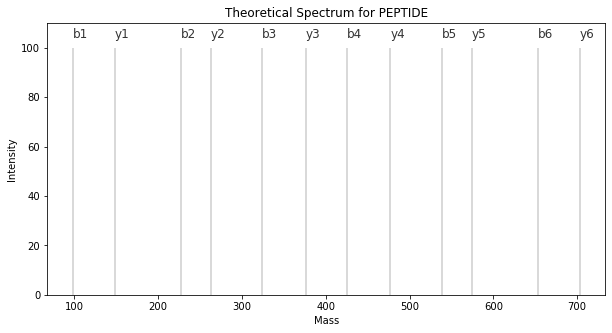

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
peptide = 'PEPTIDE'

frag_dict = get_frag_dict(parse(peptide), constants.mass_dict)

db_frag = list(frag_dict.values())
db_int = [100 for _ in db_frag]

plt.figure(figsize=(10,5))
plt.vlines(db_frag, 0, db_int, "k", label="DB", alpha=0.2)

for _ in frag_dict.keys():
    plt.text(frag_dict[_], 104, _, fontsize=12, alpha = 0.8)
    
plt.title('Theoretical Spectrum for {}'.format(peptide))
plt.xlabel('Mass')
plt.ylabel('Intensity')
plt.ylim([0,110])
plt.show()

### Spectra

The function `get_spectrum` returns a tuple with the following content:

* precursor mass
* peptide sequence
* fragmasses
* fragtypes

Likewise, `get_spectra` returns a list of tuples. We employ a list of tuples here as this way we can sort them easily by precursor mass.

In [ ]:
#export
@njit
def get_spectrum(peptide, mass_dict):
    parsed_peptide = parse(peptide)

    fragmasses, fragtypes = get_fragmass(parsed_peptide, mass_dict)
    sortindex = np.argsort(fragmasses)
    fragmasses = fragmasses[sortindex]
    fragtypes = fragtypes[sortindex]

    precmass = get_precmass(parsed_peptide, mass_dict)

    return (precmass, peptide, fragmasses, fragtypes)

@njit
def get_spectra(peptides, mass_dict):
    spectra = []

    for i in range(len(peptides)):
        spectra.append(get_spectrum(peptides[i], mass_dict))

    return spectra

In [ ]:
print(get_spectra(['PEPTIDE'], constants.mass_dict))

[(799.3599642034599, 'PEPTIDE', array([ 98.06004033, 148.06043425, 227.10263343, 263.08737735,
       324.15539729, 376.17144135, 425.20307579, 477.21911985,
       538.28713979, 574.27188371, 653.31408289, 703.31447681]), array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1], dtype=int8))]


In [ ]:
#hide
def test_get_spectra():
    
    spectra = get_spectra(['PEPTIDE'], constants.mass_dict)
    
    precmass, peptide, frags, fragtypes = spectra[0]
    
    assert np.allclose(precmass, 799.3599642034599)
    
    assert peptide == 'PEPTIDE'
    
    assert np.allclose(frags, np.array([ 98.06004033, 148.06043425, 227.10263343, 263.08737735,
       324.15539729, 376.17144135, 425.20307579, 477.21911985,
       538.28713979, 574.27188371, 653.31408289, 703.31447681]))

test_get_spectra()

## Reading FASTA

To read FASTA files we use the `SeqIO` module from the `Biopython` library.
Generator expression so that we can read it one by one

Additionally we define the wrapper `read_fasta` that allows to read multiple FASTA files.

In [ ]:
#export
from Bio import SeqIO
import os
from glob import glob

def read_fasta_file(fasta_filename=""):
    """
    given a fasta_file read fasta file line by line, return progress
    """
    with open(fasta_filename, "rt") as handle:
        iterator = SeqIO.parse(handle, "fasta")
        while iterator:
            try:
                record = next(iterator)
                parts = record.id.split("|")  # pipe char
                if len(parts) > 1:
                    id = parts[1]
                else:
                    id = record.name
                sequence = str(record.seq)
                entry = {
                    "id": id,
                    "name": record.name,
                    "description": record.description,
                    "sequence": sequence,
                }

                yield entry
            except StopIteration:
                break


def read_fasta_file_entries(fasta_filename=""):
    """
    Function to count entries in fasta file
    """
    with open(fasta_filename, "rt") as handle:
        iterator = SeqIO.parse(handle, "fasta")
        count = 0
        while iterator:
            try:
                record = next(iterator)
                count+=1
            except StopIteration:
                break

        return count



def read_fasta(path):
    """
    Wrapper to read multiple files.
    """
    if os.path.isdir(path):
        paths = glob(path + "/*.fasta")
    else:
        paths = glob(path)

    if len(paths) == 0:
        raise KeyError("Not a valid Fasta Path: {}.".format(path))

    for fasta_file in paths:
        for entry in read_fasta_file(fasta_file):
            yield entry

def check_sequence(element, AAs):
    """
    Checks wheter a sequence from a FASTA entry contains valid AAs
    """
    if not set(element['sequence']).issubset(AAs):
        print('Error. This FASTA Entry contains unknown AAs and will be skipped: \n {}\n'.format(element))
        return False
    else:
        return True

In [ ]:
#load example fasta file

fasta_path = '../testfiles/test.fasta'

list(read_fasta(fasta_path))[0]

{'id': 'A0PJZ0',
 'name': 'sp|A0PJZ0|A20A5_HUMAN',
 'description': 'sp|A0PJZ0|A20A5_HUMAN Putative ankyrin repeat domain-containing protein 20A5 OS=Homo sapiens OX=9606 GN=ANKRD20A5P PE=5 SV=1',
 'sequence': 'MKLFGFRSRRGQTVLGSIDHLYTGSGYRIRYSELQKIHKAAVKGDAAEMERCLARRSGDLDALDKQHRTALHLACASGHVKVVTLLVNRKCQIDIYDKENRTPLIQAVHCQEEACAVILLEHGANPNLKDIYGNTALHYAVYSESTSLAEKLLFHGENIEALDKV'}

## Peptide Dictionary

In order to efficiently store peptides we rely on the python in dictionary. The idea is to have a dictionary with peptides as keys and indicies to proteins as values. This way we can quickly look up to which protein a peptide belongs to. The function `add_to_pept_dict` uses a regular python dictionary and allows to add peptides and stores indicies to the originating proteins as a list. If a peptide is already present in the dictionary the list is appended. The function returns a list of `added_peptides` which were not present in the dictionary yet.

In [ ]:
#export
def add_to_pept_dict(pept_dict, new_peptides, i):
    """
    Add peptides to the peptide dictionary
    """
    added_peptides = List()
    for peptide in new_peptides:
        if peptide in pept_dict:
            pept_dict[peptide].append(i)
        else:
            pept_dict[peptide] = [i]
            added_peptides.append(peptide)

    return pept_dict, added_peptides

In [ ]:
pept_dict = {}
new_peptides = ['ABC','DEF']

pept_dict, added_peptides = add_to_pept_dict(pept_dict, new_peptides, 0)

new_peptides = ['DEF','GHI']

pept_dict, added_peptides = add_to_pept_dict(pept_dict, new_peptides, 1)

print(pept_dict)

{'ABC': [0], 'DEF': [0, 1], 'GHI': [1]}


## Generating a library

To wrap everything up, we employ two functions `generate_library` and `generate_spectra`. The first one reads a FASTA file and generates a list of peptides, as well as the peptide dictionary and an ordered FASTA dictionary to be able to look up the protein indices laster. For the `callback` we first read the whole FASTA file to determine the total number of entries in the FASTA file.  For a typical FASTA file of 30 Mb with 40k entries, this should take less than a second. The progress of the digestion is monitored by processing the FASTA file one by one.
The function `generate_spectra` then calculates precursor masses and fragment ions. Here, we split the total_number of sequences in `1000` steps to be able to track progress with the `callback`.

In [ ]:
#export
from collections import OrderedDict

def generate_library(mass_dict, fasta_path, callback = None, contaminants_path = None, **kwargs):
    """
    Function to generate a library from a fasta file
    """
    to_add = List()
    fasta_dict = OrderedDict()
    fasta_index = 0

    pept_dict = {}
    
    if type(fasta_path) is str:
        fasta_path = [fasta_path]
        n_fastas = 1
        
    elif type(fasta_path) is list:
        n_fastas = len(fasta_path)
    
    for f_id, fasta_file in enumerate(fasta_path):
        n_entries = read_fasta_file_entries(fasta_file)

        fasta_generator = read_fasta(fasta_file)

        for element in fasta_generator:
            if check_sequence(element, constants.AAs):
                fasta_dict[fasta_index] = element
                mod_peptides = generate_peptides(element["sequence"], **kwargs)
                pept_dict, added_seqs = add_to_pept_dict(pept_dict, mod_peptides, fasta_index)
                if len(added_seqs) > 0:
                    to_add.extend(added_seqs)

            fasta_index += 1

            if callback:
                callback(fasta_index/n_entries/n_fastas+f_id)
            
    if contaminants_path:
        fasta_generator = read_fasta(contaminants_path)

        for element in fasta_generator:
            if check_sequence(element, constants.AAs):
                fasta_dict[fasta_index] = element
                mod_peptides = generate_peptides(element["sequence"], **kwargs)
                pept_dict, added_seqs = add_to_pept_dict(pept_dict, mod_peptides, fasta_index)
                if len(added_seqs) > 0:
                    to_add.extend(added_seqs)

            fasta_index += 1
        
    return to_add, pept_dict, fasta_dict


def generate_spectra(to_add, mass_dict, callback = None):
    """
    Function to generate a library from a fasta file
    """

    if len(to_add) > 0:

        if callback: #Chunk the spectra to get a progress_bar
            spectra = []

            stepsize = int(np.ceil(len(to_add)/1000))

            for i in range(0, len(to_add), stepsize):
                sub = to_add[i:i + stepsize]
                spectra.extend(get_spectra(sub, mass_dict))
                callback((i+1)/len(to_add))

        else:
            spectra = get_spectra(to_add, mass_dict)
    else:
        raise ValueError("No spectra to generate.")

    return spectra

## Saving

To save the generated spectra, we rely on NumPy's NPZ format. For this we create a dictionary and save all the generated elements. The container will contain the following elements:

* `precursors`: An array containing the precursor masses
* `seqs`: An array containing the peptide sequences for the precursor masses
* `pept_dict`: A peptide dictionary to look up the peptides and return their FASTA index
* `fasta_dict`: A fasta dictionary to look up the FASTA entry based on a pept_dict index
* `fragmasses`: An array containing the fragment masses. Unoccupied cells are filled with -1
* `fragtypes:`: An array containg the fragment types. 0 equals b-ions and 1 equals y-ions. Unoccupied cells are filled with -1
* `bounds`: An integer array containing the upper bounds for the fragment masses / types array. This is needed to quickly slice the data.

All arrays are sorted according to the precursor mass.

In [ ]:
#export
from alphapept.io import list_to_numpy_f32


def save_library(spectra, pept_dict, fasta_dict, library_path, **kwargs):
    """
    Function to save a library to the *.npz format.
    """

    precmasses, seqs, fragmasses, fragtypes = zip(*spectra)
    sortindex = np.argsort(precmasses)

    to_save = {}

    to_save["precursors"] = np.array(precmasses)[sortindex]
    to_save["seqs"] = np.array(seqs)[sortindex]
    to_save["pept_dict"] = pept_dict
    to_save["fasta_dict"] = fasta_dict
    to_save["fragmasses"] = list_to_numpy_f32(np.array(fragmasses)[sortindex])
    to_save["fragtypes"] = list_to_numpy_f32(np.array(fragtypes)[sortindex])

    to_save["bounds"] = np.sum(to_save['fragmasses']>=0,axis=0).astype(np.int64)

    np.savez(library_path, **to_save)

    return library_path

In [ ]:
#hide
from nbdev.export import *
notebook2script()

Converted 01_chem.ipynb.
Converted 02_io.ipynb.
Converted 03_fasta.ipynb.
Converted 04_feature_finding.ipynb.
Converted 05_search.ipynb.
Converted 06_score.ipynb.
Converted 07_recalibration.ipynb.
Converted 08_quantification.ipynb.
Converted 09_matching.ipynb.
Converted 10_constants.ipynb.
Converted 11_settings.ipynb.
Converted 12_runner.ipynb.
Converted FF_parallel.ipynb.
Converted index.ipynb.
